<h1 style="text-align:center; font-size:35px"> Brain Hemorrhage Detection </h1>

## Imports

In [1]:
import os
import shutil
from keras.models import load_model
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Setting sessions for GPU
from tensorflow.keras.backend import set_session
tf_config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session = tf.Session(config=tf_config)
graph = tf.get_default_graph()
set_session(session)

# Hiding Warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings('ignore')

import random
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tqdm import tqdm
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
from skimage.transform import resize, rescale, rotate
from torch.utils.data import Dataset
from torchvision.transforms import Compose

<h1><center>Classification Training</center></h1>


## Image Augmentation

In [ ]:
params = {'rescale':1./255, 'zoom_range':0.2, 'width_shift_range':0.2, 'height_shift_range':0.2, 'shear_range':0.2, 'horizontal_flip':True, 'featurewise_std_normalization':True, 'featurewise_center':True, 'fill_mode':'nearest'}

# Image Data Generator configuration
image_gen = ImageDataGenerator(**params)
    
# Train Split
train_generator  = image_gen.flow_from_directory(
directory= 'E:\Resized_Data/train',
batch_size=10,
target_size=(224, 224),
class_mode="categorical",
shuffle=True,
seed=42)
    
# Validation Split
validation_generator  = image_gen.flow_from_directory(
directory= 'E:\Resized_Data/validation',
batch_size=10,
target_size=(224, 224),
class_mode="categorical",
shuffle=True,
seed=42)
    
# Test Split
test_generator  = image_gen.flow_from_directory(
directory= 'E:\Resized_Data/test',
batch_size=16,
target_size=(224, 224),
class_mode="categorical",
shuffle=True,
seed=42)

## Adding layers Function

In [ ]:
def layers_addition(base_model):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024,activation='relu')(x) # We add dense layers so that the model can learn more complex functions and classify for better results.
    x = layers.Dense(1024,activation='relu')(x) # Dense layer 2
    x = layers.Dense(512,activation='relu')(x)  # Dense layer 3
    last_layer = layers.Dense(3,activation='sigmoid')(x) # Final layer with sigmoid

    model = Model(inputs=base_model.input, outputs=last_layer)
    return model

## DenseNet169

In [ ]:
base_model = None
base_model = DenseNet169(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

### Modification in Layers


In [5]:
denseNet_model = layers_addition(base_model)

### Compiling Loss

In [6]:
denseNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])


### Model Fitting

In [7]:
with graph.as_default():
    set_session(session)
    history = denseNet_model.fit_generator(
        train_generator,
        validation_data = validation_generator,
        steps_per_epoch = 100, # 100
        epochs = 10,
        validation_steps = 50, # 50
        verbose = 2)


Epoch 1/10
100/100 - 96s - loss: 0.8756 - acc: 0.5752 - val_loss: 0.8976 - val_acc: 0.4760 
Epoch 2/10
100/100 - 29s - loss: 0.8143 - acc: 0.6145 - val_loss: 0.8351 - val_acc: 0.5400 
Epoch 3/10
100/100 - 30s - loss: 0.7943 - acc: 0.6584 - val_loss: 0.7887 - val_acc: 0.5912 
Epoch 4/10
100/100 - 29s - loss: 0.7643 - acc: 0.6264 - val_loss: 0.7754 - val_acc: 0.5547 
Epoch 5/10
100/100 - 29s - loss: 0.7785 - acc: 0.6512 - val_loss: 0.7461 - val_acc: 0.5741
Epoch 6/10
100/100 - 29s - loss: 0.7895 - acc: 0.6125 - val_loss: 0.7682 - val_acc: 0.6502 
Epoch 7/10
100/100 - 31s - loss: 0.6984 - acc: 0.6632 - val_loss: 0.7411 - val_acc: 0.6745 
Epoch 8/10
100/100 - 27s - loss: 0.6100 - acc: 0.6941 - val_loss: 0.7054 - val_acc: 0.6854 
Epoch 9/10
100/100 - 27s - loss: 0.5845 - acc: 0.7214 - val_loss: 0.6812 - val_acc: 0.6951
Epoch 10/10
100/100 - 22s - loss: 0.5412 - acc: 0.7584 - val_loss: 0.6378 - val_acc: 0.7242



### Plot Curves

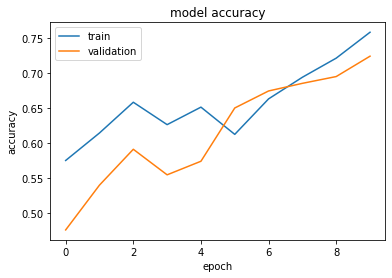

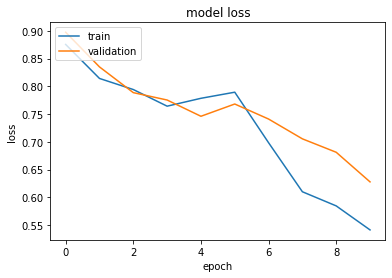

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
if not os.path.exists('DenseNetModel'):
    os.makedirs('DenseNetModel')
    
model.save_weights('DenseNetModel/weights.h5')

## ResNet50

In [ ]:
base_model = None
base_model = ResNet50(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

### Modifications in layers

In [ ]:
ResNet_model = layers_addition(base_model)

### Compile Loss

In [ ]:
ResNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

### Model Fitting

In [ ]:
with graph.as_default():
    set_session(session)
    history = ResNet_model.fit_generator(
        train_generator,
        validation_data = validation_generator,
        steps_per_epoch = 100, # 100
        epochs = 10,
        validation_steps = 50, # 50
        verbose = 2)

### Plotting Accuracy and Loss Curves

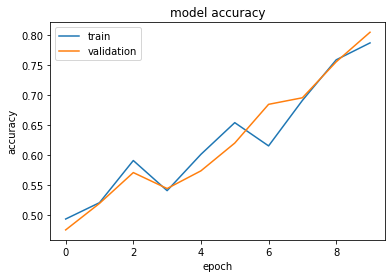

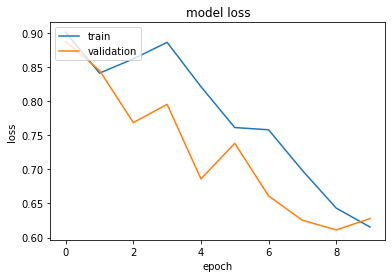

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Saving Model

In [ ]:
if not os.path.exists('ResNetModel'):
    os.makedirs('ResNetModel')
    
model.save_weights('ResNetModel/weights.h5')

## VGG16

In [ ]:
base_model = None
base_model = VGG16(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

### Modifications in layers

In [ ]:
VGG_model = layers_addition(base_model)

### Compile Loss

In [ ]:
VGG_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

### Model Fitting

In [ ]:
with graph.as_default():
    set_session(session)
    history = VGG_model.fit_generator(
        train_generator,
        validation_data = validation_generator,
        steps_per_epoch = 100, # 100
        epochs = 10,
        validation_steps = 50, # 50
        verbose = 2)

### Plotting Accuracy and Loss Curves

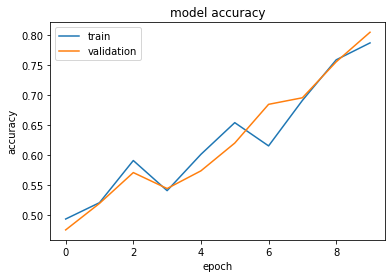

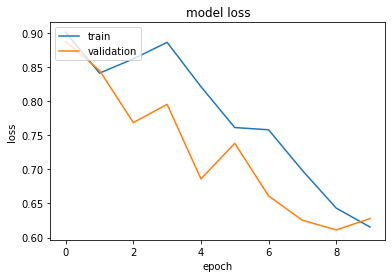

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Saving Model

In [ ]:
if not os.path.exists('VGGModel'):
    os.makedirs('VGGModel')
    
model.save_weights('VGGModel/weights.h5')

## MobileNet_v2

In [ ]:
base_model = None
base_model = MobileNetV2(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

### Modifications in layers

In [ ]:
mobilenet_model = layers_addition(base_model)

### Compile Loss

In [ ]:
mobilenet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

### Model Fitting

In [ ]:
with graph.as_default():
    set_session(session)
    history = mobilenet_model.fit_generator(
        train_generator,
        validation_data = validation_generator,
        steps_per_epoch = 100, # 100
        epochs = 10,
        validation_steps = 50, # 50
        verbose = 2)

### Plotting Accuracy and Loss Curves

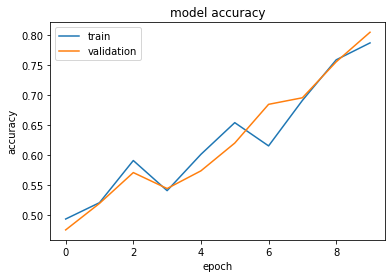

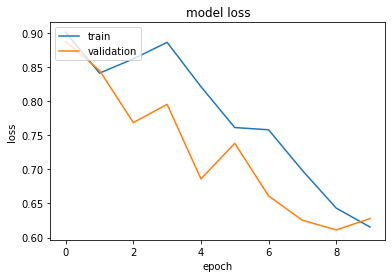

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Saving Model

In [ ]:
if not os.path.exists('MobileNetV2'):
    os.makedirs('MobileNetV2')
    
model.save_weights('MobileNetV2/weights.h5')

<h1><center>Segementation Training</center></h1>


# Pre-Processing Functions

In [2]:
def crop_sample(x):
    volume, mask = x
    volume[volume < np.max(volume) * 0.1] = 0
    z_projection = np.max(np.max(np.max(volume, axis=-1), axis=-1), axis=-1)
    z_nonzero = np.nonzero(z_projection)
    z_min = np.min(z_nonzero)
    z_max = np.max(z_nonzero) + 1
    y_projection = np.max(np.max(np.max(volume, axis=0), axis=-1), axis=-1)
    y_nonzero = np.nonzero(y_projection)
    y_min = np.min(y_nonzero)
    y_max = np.max(y_nonzero) + 1
    x_projection = np.max(np.max(np.max(volume, axis=0), axis=0), axis=-1)
    x_nonzero = np.nonzero(x_projection)
    x_min = np.min(x_nonzero)
    x_max = np.max(x_nonzero) + 1
    return (
        volume[z_min:z_max, y_min:y_max, x_min:x_max],
        mask[z_min:z_max, y_min:y_max, x_min:x_max],
    )

In [3]:
def pad_sample(x):
    volume, mask = x
    a = volume.shape[1]
    b = volume.shape[2]
    if a == b:
        return volume, mask
    diff = (max(a, b) - min(a, b)) / 2.0
    if a > b:
        padding = ((0, 0), (0, 0), (int(np.floor(diff)), int(np.ceil(diff))))
    else:
        padding = ((0, 0), (int(np.floor(diff)), int(np.ceil(diff))), (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)
    return volume, mask

In [4]:
def resize_sample(x, size=256):
    volume, mask = x
    v_shape = volume.shape
    out_shape = (v_shape[0], size, size)
    mask = resize(
        mask,
        output_shape=out_shape,
        order=0,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    out_shape = out_shape + (v_shape[3],)
    volume = resize(
        volume,
        output_shape=out_shape,
        order=2,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    return volume, mask

In [5]:
def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99))
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume

In [6]:
class BrainSegmentationDataset(Dataset):

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        seed=42,
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=10)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform
    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor

def transforms(scale=None, angle=None, flip_prob=None):
    transform_list = []

    if scale is not None:
        transform_list.append(Scale(scale))
    if angle is not None:
        transform_list.append(Rotate(angle))
    if flip_prob is not None:
        transform_list.append(HorizontalFlip(flip_prob))

    return Compose(transform_list)


class Scale(object):

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, mask = sample

        img_size = image.shape[0]

        scale = np.random.uniform(low=1.0 - self.scale, high=1.0 + self.scale)

        image = rescale(
            image,
            (scale, scale),
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )
        mask = rescale(
            mask,
            (scale, scale),
            order=0,
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )

        if scale < 1.0:
            diff = (img_size - image.shape[0]) / 2.0
            padding = ((int(np.floor(diff)), int(np.ceil(diff))),) * 2 + ((0, 0),)
            image = np.pad(image, padding, mode="constant", constant_values=0)
            mask = np.pad(mask, padding, mode="constant", constant_values=0)
        else:
            x_min = (image.shape[0] - img_size) // 2
            x_max = x_min + img_size
            image = image[x_min:x_max, x_min:x_max, ...]
            mask = mask[x_min:x_max, x_min:x_max, ...]

        return image, mask

In [7]:
class Rotate(object):

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, mask = sample

        angle = np.random.uniform(low=-self.angle, high=self.angle)
        image = rotate(image, angle, resize=False, preserve_range=True, mode="constant")
        mask = rotate(
            mask, angle, resize=False, order=0, preserve_range=True, mode="constant"
        )
        return image, mask

In [8]:
class HorizontalFlip(object):

    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, sample):
        image, mask = sample

        if np.random.rand() > self.flip_prob:
            return image, mask

        image = np.fliplr(image).copy()
        mask = np.fliplr(mask).copy()

        return image, mask

# U-Net Model

In [9]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Dice Loss

In [10]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [11]:
def log_images(x, y_true, y_pred, channel=1):
    images = []
    x_np = x[:, channel].cpu().numpy()
    y_true_np = y_true[:, 0].cpu().numpy()
    y_pred_np = y_pred[:, 0].cpu().numpy()
    for i in range(x_np.shape[0]):
        image = gray2rgb(np.squeeze(x_np[i]))
        image = outline(image, y_pred_np[i], color=[255, 0, 0])
        image = outline(image, y_true_np[i], color=[0, 255, 0])
        images.append(image)
    return images

In [12]:
def gray2rgb(image):
    w, h = image.shape
    image += np.abs(np.min(image))
    image_max = np.abs(np.max(image))
    if image_max > 0:
        image /= image_max
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = image * 255
    return ret

In [13]:
def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image

# Data Loader

In [14]:
def data_loaders(batch_size, workers, image_size, aug_scale, aug_angle):
    dataset_train, dataset_valid = datasets("kaggle_3m", image_size, aug_scale, aug_angle)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

In [15]:
def datasets(images, image_size, aug_scale, aug_angle):
    train = BrainSegmentationDataset(
        images_dir=images,
        subset="train",
        image_size=image_size,
        transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
    )
    valid = BrainSegmentationDataset(
        images_dir=images,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
    )
    return train, valid

# Dice Cofficient Helper Functions

In [16]:
def dsc(y_pred, y_true):
    y_pred = np.round(y_pred).astype(int)
    y_true = np.round(y_true).astype(int)
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))


def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true)
    return dsc_dict


def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list

In [17]:
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

In [18]:
def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))

def log_scalar_summary(tag, value, step):
    print("epoch {} | {}: {}".format(step + 1, tag, value))

# Dice Cofficient Plotting

In [19]:
def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

# Setting Parameters

In [47]:
batch_size = 16
epochs = 20
lr = 0.00001
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

In [21]:
loader_train, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle)

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


# Training

In [19]:
def train_validate(loader_train, loader_valid):
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    loaders = {"train": loader_train, "valid": loader_valid}
    
    unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
    unet.to(device)
    
    dsc_loss = DiceLoss()
    best_validation_dsc = 0.0
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train = []
    loss_valid = []
    
    step = 0
    
    for epoch in range(epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()
    
            validation_pred = []
            validation_true = []
    
            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1
    
                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
    
                    loss = dsc_loss(y_pred, y_true)
    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                log_loss_summary(loss_valid, epoch, prefix="val_")
                mean_dsc = np.mean(
                    dsc_per_volume(
                        validation_pred,
                        validation_true,
                        loader_valid.dataset.patient_slice_index,
                    )
                )
                log_scalar_summary("val_dsc", mean_dsc, epoch)
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    torch.save(unet.state_dict(), os.path.join(weights, "unet.pt"))
                loss_valid = []
    
    print("\nBest validation mean DSC: {:4f}\n".format(best_validation_dsc))
    
    state_dict = torch.load(os.path.join(weights, "unet.pt"))
    unet.load_state_dict(state_dict)
    unet.eval()
    
    input_list = []
    pred_list = []
    true_list = []
    
    for i, data in enumerate(loader_valid):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)
        with torch.set_grad_enabled(False):
            y_pred = unet(x)
            y_pred_np = y_pred.detach().cpu().numpy()
            pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
            y_true_np = y_true.detach().cpu().numpy()
            true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
            x_np = x.detach().cpu().numpy()
            input_list.extend([x_np[s] for s in range(x_np.shape[0])])
            
    volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )
    
    dsc_dist = dsc_distribution(volumes)

    dsc_dist_plot = plot_dsc(dsc_dist)
    imsave("./dsc.png", dsc_dist_plot)

    for p in volumes:
        x = volumes[p][0]
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        for s in range(x.shape[0]):
            image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
            image = outline(image, y_pred[s, 0], color=[255, 0, 0])
            image = outline(image, y_true[s, 0], color=[0, 255, 0])
            filename = "{}-{}.png".format(p, str(s).zfill(2))
            filepath = os.path.join("./output/", filename)
            imsave(filepath, image)


epoch 1 | loss: 0.8832826469708415
epoch 1 | val_loss: 0.9512729021635923
epoch 1 | val_dsc: 0.14683285645068267
epoch 2 | loss: 0.8421266837027467
epoch 2 | val_loss: 0.9469888481226835
epoch 2 | val_dsc: 0.4097885839928807
epoch 3 | loss: 0.8267634658558854
epoch 3 | val_loss: 0.9456368630582636
epoch 3 | val_dsc: 0.5139873784187963
epoch 4 | loss: 0.8194002295003354
epoch 4 | val_loss: 0.9451146207072518
epoch 4 | val_dsc: 0.5270131876337053
epoch 5 | loss: 0.8144592689078989
epoch 5 | val_loss: 0.9434991939501329
epoch 5 | val_dsc: 0.480249098537306
epoch 6 | loss: 0.8104684943134345
epoch 6 | val_loss: 0.9429027248512615
epoch 6 | val_dsc: 0.5127283336180751
epoch 7 | loss: 0.8068520137407247
epoch 7 | val_loss: 0.9452146643942053
epoch 7 | val_dsc: 0.570665085222721
epoch 8 | loss: 0.8035482819219237
epoch 8 | val_loss: 0.9421391216191378
epoch 8 | val_dsc: 0.5714520831158235
epoch 9 | loss: 0.8003543233408511
epoch 9 | val_loss: 0.941573441028595
epoch 9 | val_dsc: 0.59068128347

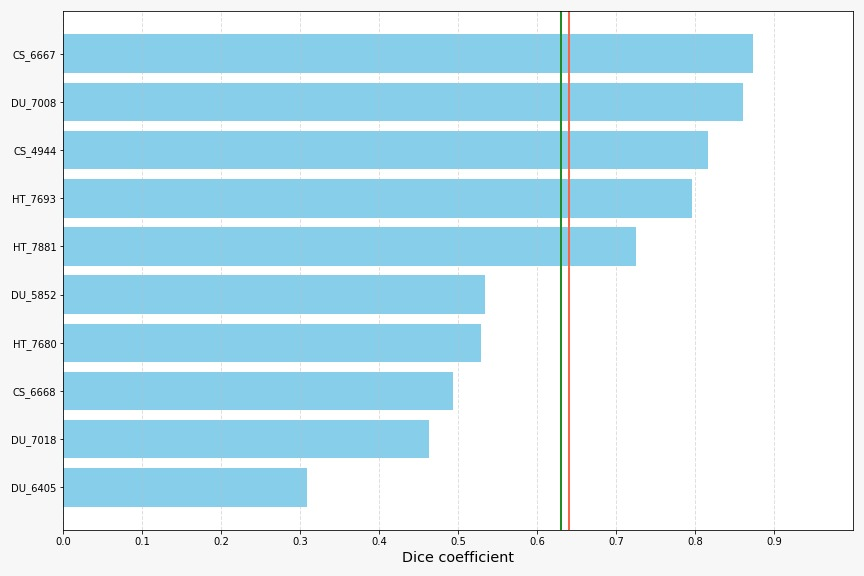

In [7]:
train_validate(loader_train, loader_valid)

<h1><center>Testing Phase</center></h1>

In [169]:
def Segmentation(loader_test):
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    
    unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
    unet.to(device)
    unet.load_state_dict(torch.load('unet.pt'))
    unet.eval()
    
    input_list = []
    pred_list = []
    true_list = []
    
    for i, data in enumerate(loader_test):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)
        with torch.set_grad_enabled(False):
            y_pred = unet(x)
            y_pred_np = y_pred.detach().cpu().numpy()
            pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
            y_true_np = y_true.detach().cpu().numpy()
            true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
            x_np = x.detach().cpu().numpy()
            input_list.extend([x_np[s] for s in range(x_np.shape[0])])
        break
            
    volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )
    

    for p in volumes:
        x = volumes[p][0]
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        for s in range(x.shape[0]):
            image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
            image = outline(image, y_pred[s, 0], color=[255, 0, 0])
            image = outline(image, y_true[s, 0], color=[0, 255, 0])
            plt.figure(figsize=(20,20))
            plt.subplot(4,4,s+1)
            plt.axis('off')
            plt.imshow(image)

## Sample Segmentation Results

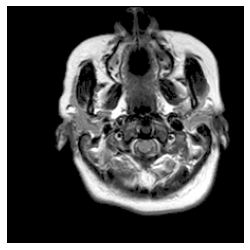

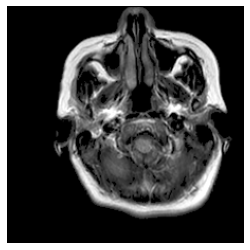

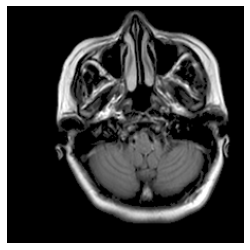

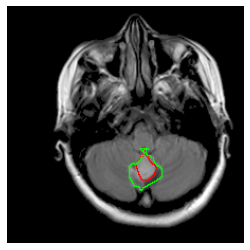

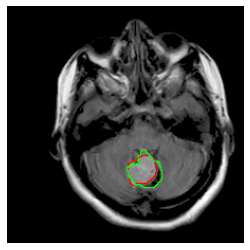

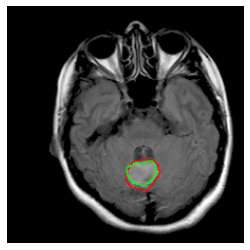

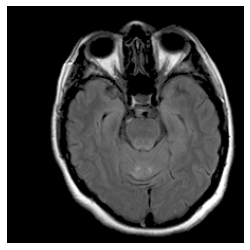

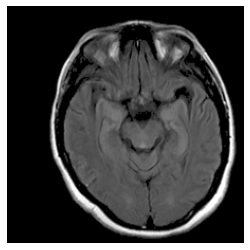

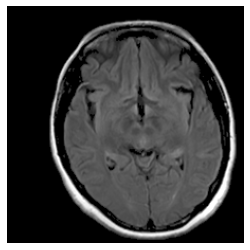

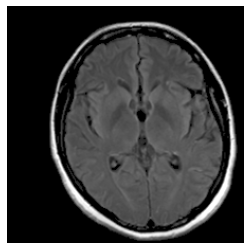

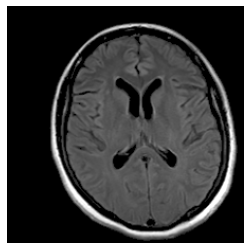

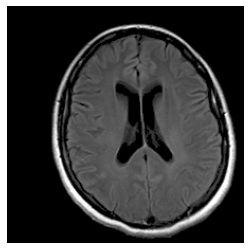

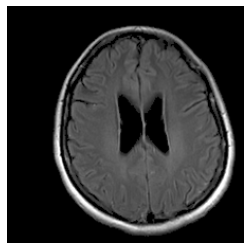

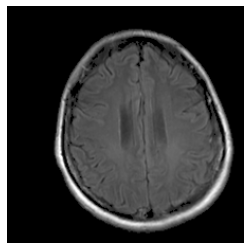

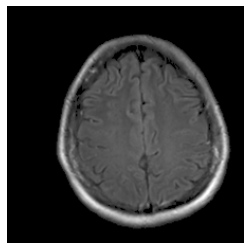

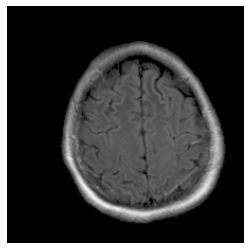

In [170]:
Segmentation(loader_valid)